In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sodapy import Socrata
from sklearn.preprocessing import StandardScaler


In [4]:
client = Socrata("www.datos.gov.co", None)

where_query = """
FechaObservacion >= '2015-01-01T00:00:00'
AND FechaObservacion <= '2023-12-31T23:59:59'
AND Departamento IN ('NARIÑO', 'CUNDINAMARCA')
AND DescripcionSensor IN ('Humedad del aire 2 mt')
"""

chunk = 500000
offset = 0
all_rows = []

while True:
    data = client.get(
        "uext-mhny",
        where=where_query,
        limit=chunk,
        offset=offset
    )
    
    if not data:
        break

    all_rows.extend(data)
    offset += chunk
    print(f"Descargadas → {len(all_rows):,} filas")

df = pd.DataFrame.from_records(all_rows)

# Parsear la fecha sin cambiar el nombre de la columna
df["fechaobservacion"] = pd.to_datetime(df["fechaobservacion"], errors="coerce")


Descargadas → 500,000 filas
Descargadas → 1,000,000 filas
Descargadas → 1,500,000 filas
Descargadas → 2,000,000 filas
Descargadas → 2,500,000 filas
Descargadas → 3,000,000 filas
Descargadas → 3,500,000 filas
Descargadas → 4,000,000 filas
Descargadas → 4,500,000 filas
Descargadas → 5,000,000 filas
Descargadas → 5,500,000 filas
Descargadas → 6,000,000 filas
Descargadas → 6,500,000 filas
Descargadas → 7,000,000 filas
Descargadas → 7,500,000 filas
Descargadas → 7,942,728 filas


In [23]:
df_humedad = pd.read_csv("datos_filtrados_humedad_suelo.csv")

In [24]:
df_humedad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7942728 entries, 0 to 7942727
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   codigoestacion     int64  
 1   codigosensor       int64  
 2   fechaobservacion   object 
 3   valorobservado     float64
 4   nombreestacion     object 
 5   departamento       object 
 6   municipio          object 
 7   zonahidrografica   object 
 8   latitud            float64
 9   longitud           float64
 10  descripcionsensor  object 
 11  unidadmedida       object 
dtypes: float64(3), int64(2), object(7)
memory usage: 727.2+ MB


In [25]:
resumen = pd.DataFrame({
    "tipo": df_humedad.dtypes,
    "nulos": df_humedad.isnull().sum(),
    "% nulos": df_humedad.isnull().mean()*100,
    "duplicados": df_humedad.duplicated().sum(),
})
resumen

,tipo,nulos,% nulos,duplicados
codigoestacion,int64,0,0.0,178108
codigosensor,int64,0,0.0,178108
fechaobservacion,object,0,0.0,178108
valorobservado,float64,0,0.0,178108
nombreestacion,object,0,0.0,178108
departamento,object,0,0.0,178108
municipio,object,0,0.0,178108
zonahidrografica,object,0,0.0,178108
latitud,float64,0,0.0,178108
longitud,float64,0,0.0,178108


In [27]:
# Parsear la fecha sin cambiar el nombre de la columna
df_humedad["fechaobservacion"] = pd.to_datetime(df_humedad["fechaobservacion"], errors="coerce")

# Eliminar duplicados

df_humedad = df_humedad.drop_duplicates()



# Separar columnas a usar

df_humedad = df_humedad[['fechaobservacion', 'municipio', 'departamento', 'valorobservado']]


# Crear columna de año-mes

df_humedad['mes'] = df_humedad['fechaobservacion'].dt.to_period('M')



# Agrupar por mes y municipio
df_humedad = (df.groupby(['mes', 'municipio'], as_index=False).agg({
          'departamento': 'first',
          'valorobservado': 'mean',
        }))



In [ ]:
df_humedad.to_csv("datos_proyecto_humedad.csv", index=False)


### Cargar base filrada de humedad 

In [20]:
df = pd.read_csv("datos_proyecto_humedad.csv")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3997 entries, 0 to 3996
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mes             3997 non-null   object 
 1   municipio       3997 non-null   object 
 2   departamento    3997 non-null   object 
 3   valorobservado  3997 non-null   float64
 4   riesgo_humedad  3997 non-null   object 
dtypes: float64(1), object(4)
memory usage: 156.3+ KB


In [5]:
df.head()

,mes,municipio,departamento,valorobservado,riesgo_humedad
0,2015-01,BARBACOAS,NARIÑO,96.929791,riesgo_alto_alta_humedad
1,2015-01,CABRERA,CUNDINAMARCA,82.251046,riesgo_moderado_alta_humedad
2,2015-01,CONTADERO,NARIÑO,74.376569,óptimo
3,2015-01,GIRARDOT,CUNDINAMARCA,63.754032,óptimo
4,2015-01,GUASCA,CUNDINAMARCA,42.198876,riesgo_baja_humedad


In [6]:
resumen = pd.DataFrame({
    "tipo": df.dtypes,
    "nulos": df.isnull().sum(),
    "% nulos": df.isnull().mean()*100,
    "duplicados": df.duplicated().sum(),
})
resumen

,tipo,nulos,% nulos,duplicados
mes,object,0,0.0,0
municipio,object,0,0.0,0
departamento,object,0,0.0,0
valorobservado,float64,0,0.0,0
riesgo_humedad,object,0,0.0,0


In [7]:
df["valorobservado"].describe().round(2)

count    3997.00
mean       73.99
std        24.11
min         0.00
25%        72.30
50%        81.38
75%        87.11
max       100.00
Name: valorobservado, dtype: float64

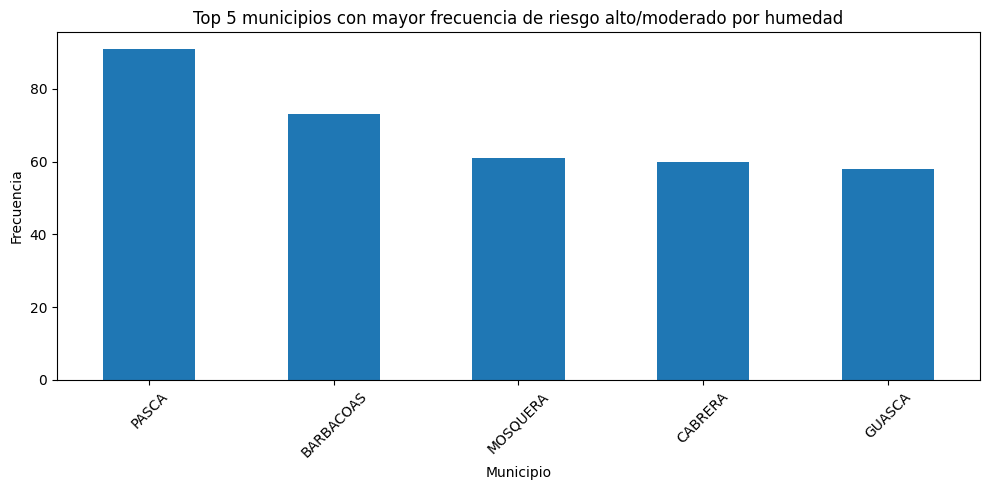

In [11]:
# 1. Filtrar condiciones de humedad moderada/alta
condicion = df[
    df['riesgo_humedad'].isin([
        'riesgo_moderado_alta_humedad',
        'riesgo_alto_alta_humedad'
    ])
]

# 2. Frecuencia por municipio
frecuencias = condicion['municipio'].value_counts()

# 3. Top 5
top5 = frecuencias.head(5)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
top5.plot(kind='bar')
plt.title('Top 5 municipios con mayor frecuencia de riesgo alto/moderado por humedad')
plt.xlabel('Municipio')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


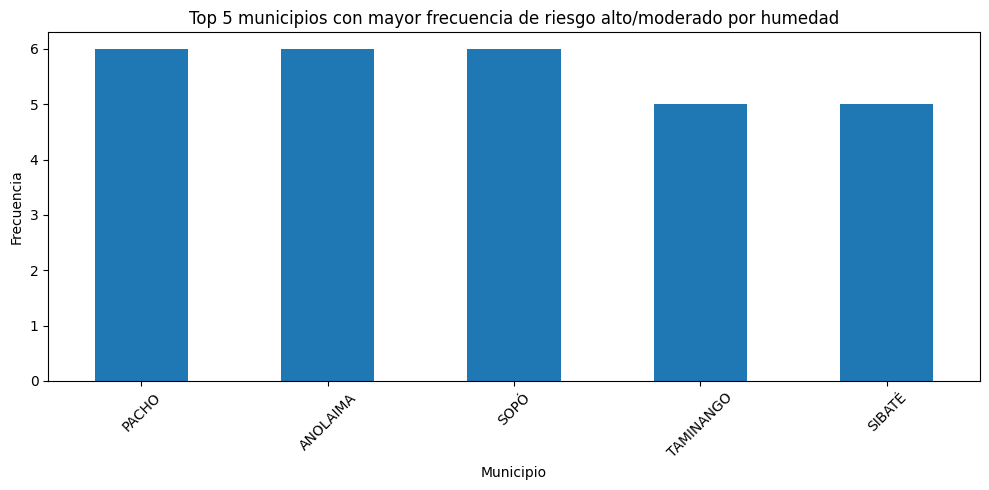

In [ ]:
# 1. Filtrar condiciones de humedad moderada/alta
condicion = df[
    df['riesgo_humedad'].isin([
        'riesgo_moderado_alta_humedad',
        'riesgo_alto_alta_humedad'
    ])
]

# 2. Frecuencia por municipio
frecuencias = condicion['municipio'].value_counts()

# 3. Top 5
top5 = frecuencias.tail(5)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
top5.plot(kind='bar')
plt.title('Top 5 municipios con menor frecuencia de riesgo alto/moderado por humedad')
plt.xlabel('Municipio')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

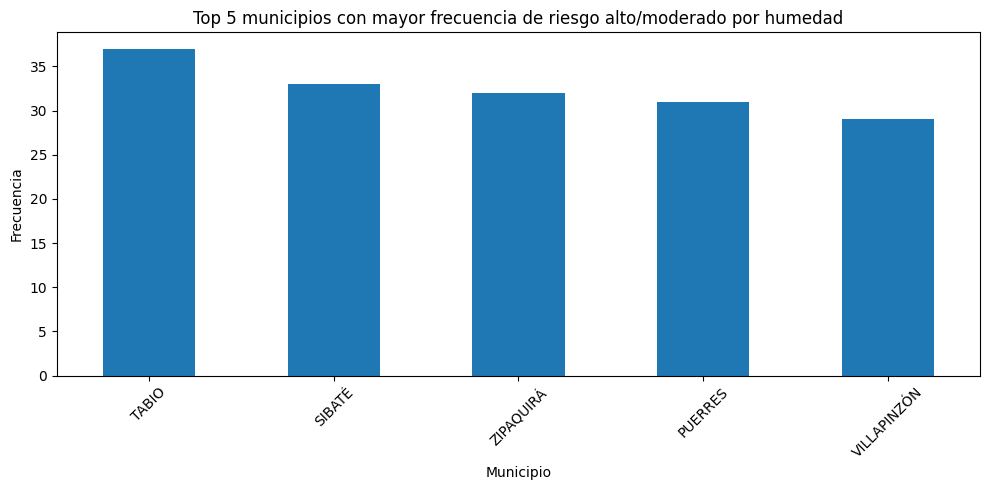

In [ ]:
# 1. Filtrar condiciones de humedad moderada/alta
condicion = df[
    df['riesgo_humedad'].isin([
        'riesgo_baja_humedad'])
]

# 2. Frecuencia por municipio
frecuencias = condicion['municipio'].value_counts()

# 3. Top 5
top5 = frecuencias.head(5)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
top5.plot(kind='bar')
plt.title('Top 5 municipios con mayor frecuencia de riesgo alto/moderado por humedad')
plt.xlabel('Municipio')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

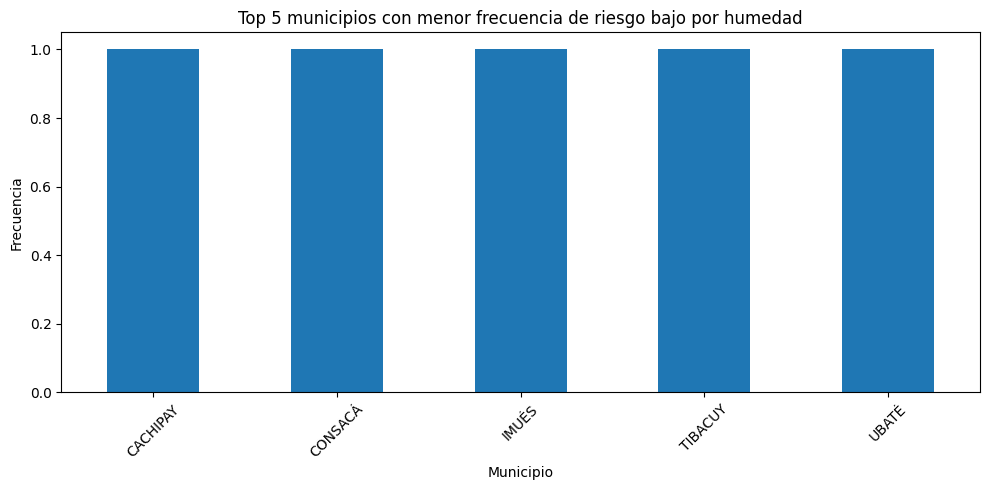

In [15]:
# 1. Filtrar condiciones de humedad moderada/alta
condicion = df[
    df['riesgo_humedad'].isin([
        'riesgo_baja_humedad'])
]

# 2. Frecuencia por municipio
frecuencias = condicion['municipio'].value_counts()

# 3. Top 5
top5 = frecuencias.tail(5)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
top5.plot(kind='bar')
plt.title('Top 5 municipios con menor frecuencia de riesgo bajo por humedad')
plt.xlabel('Municipio')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

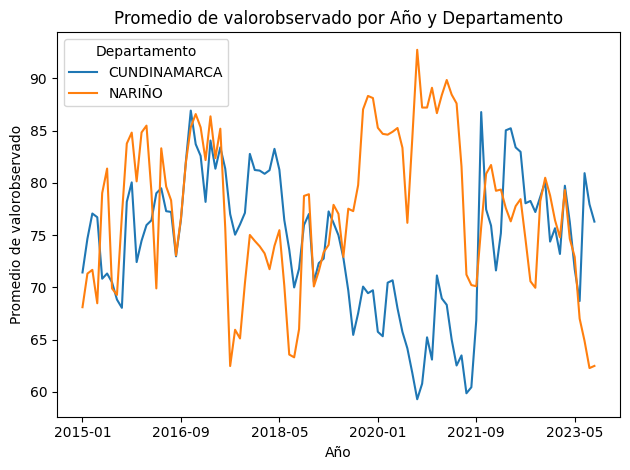

In [17]:
# Extraer año

# Agrupar por año y departamento y obtener promedio
promedio = (
    df.groupby(["mes", "departamento"])["valorobservado"]
      .mean()
      .reset_index()
)

# Pivot para graficar (columnas = departamentos)
pivot = promedio.pivot(index="mes", columns="departamento", values="valorobservado")

# Graficar
plt.figure(figsize=(12,6))
pivot.plot()
plt.title("Promedio de valorobservado por Año y Departamento")
plt.xlabel("Año")
plt.ylabel("Promedio de valorobservado")
plt.legend(title="Departamento")
plt.tight_layout()
plt.show()

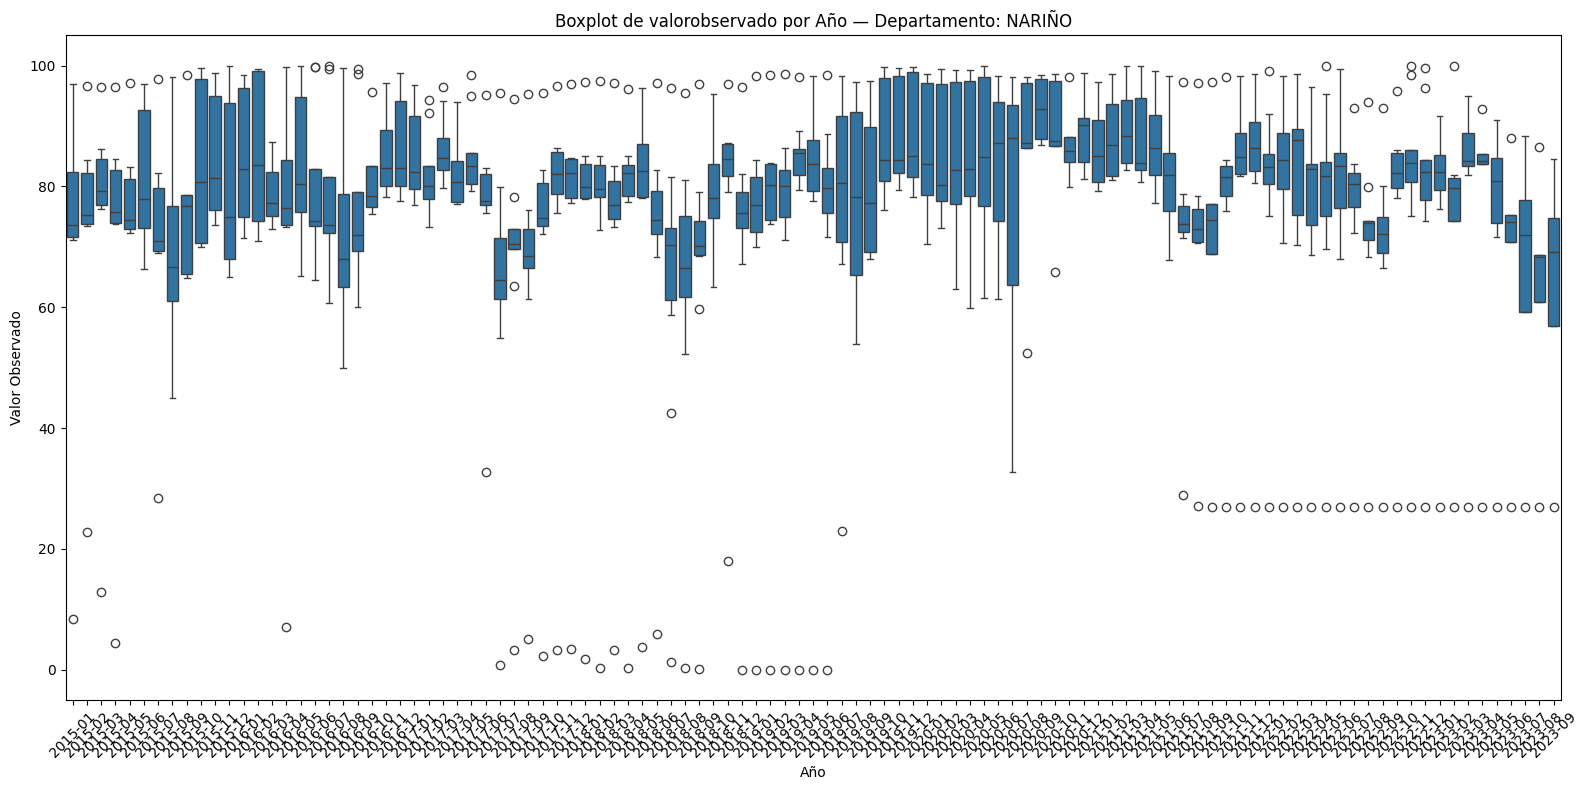

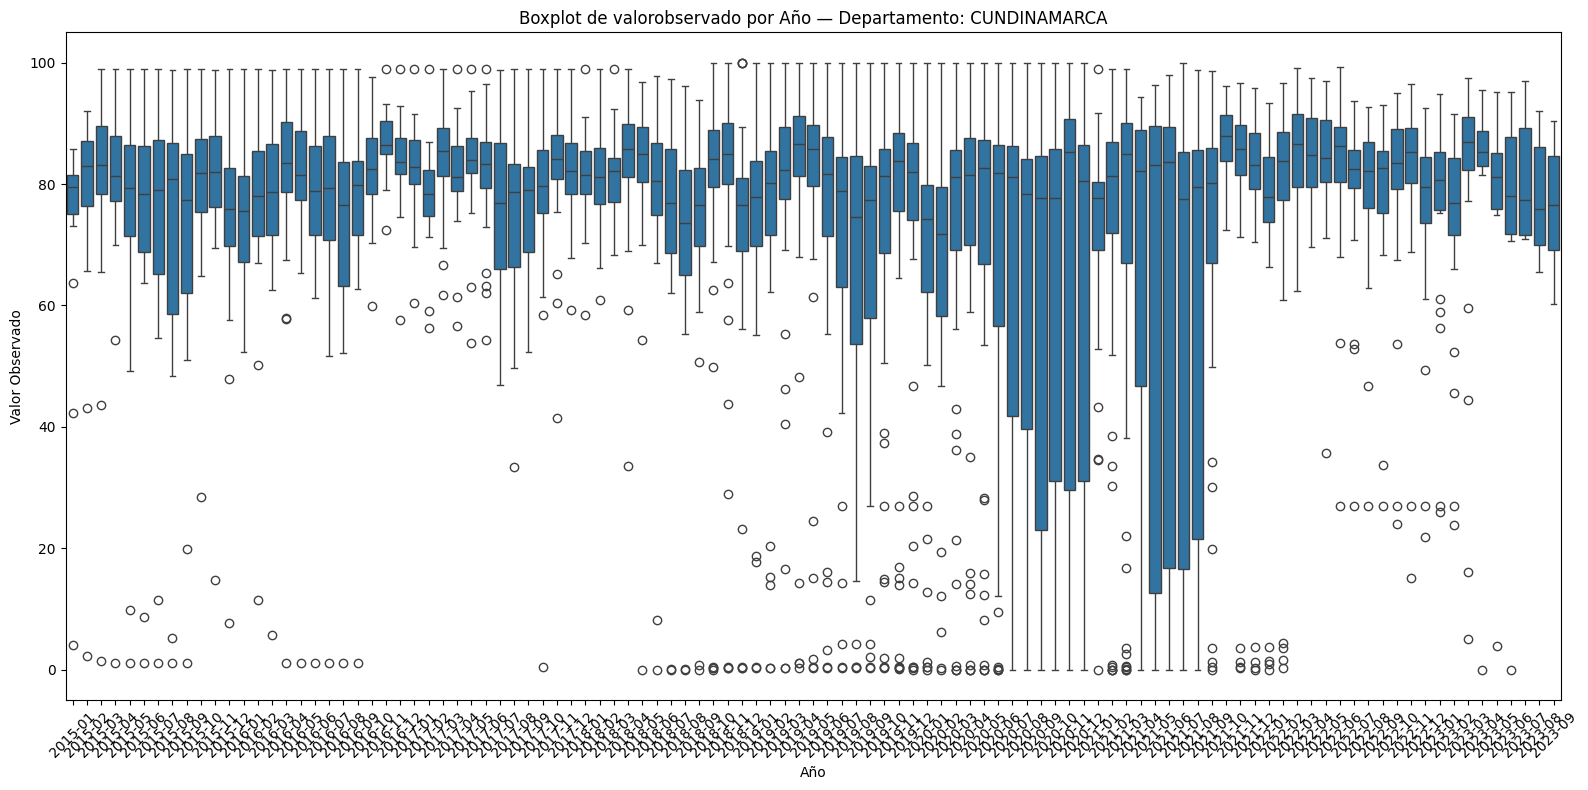

In [19]:
# Obtener lista de departamentos únicos
departamentos = df["departamento"].unique()

# Crear un boxplot para cada departamento
for depto in departamentos:
    plt.figure(figsize=(16,8))

    subset = df[df["departamento"] == depto]

    sns.boxplot(
        data=subset,
        x="mes",
        y="valorobservado"
    )

    plt.title(f"Boxplot de valorobservado por Año — Departamento: {depto}")
    plt.xlabel("Año")
    plt.ylabel("Valor Observado")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()